<a href="https://colab.research.google.com/github/AvantiShri/colab_notebooks/blob/master/profile_models/PerSliceGradAndDeepSHAP_InterpretSPI1ProfileModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#%tensorflow_version 1.x

Load the model

In [2]:
#Download the keras model
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/9e9880e93fef6c41b5ac40f33142b80305aae4f2/bqtls/profile_model/Spi1ProfileModel_rc.h5 -O Spi1ProfileModel_rc.h5

--2020-10-02 18:36:15--  https://raw.githubusercontent.com/AvantiShri/model_storage/9e9880e93fef6c41b5ac40f33142b80305aae4f2/bqtls/profile_model/Spi1ProfileModel_rc.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2078176 (2.0M) [application/octet-stream]
Saving to: ‘Spi1ProfileModel_rc.h5’

Spi1ProfileModel_rc 100%[===================>]   1.98M  --.-KB/s    in 0.1s    

2020-10-02 18:36:16 (20.6 MB/s) - ‘Spi1ProfileModel_rc.h5’ saved [2078176/2078176]



In [3]:
!pip install keras_genomics # we need to install this because model has revcomp layers

In [4]:
try:
  import tensorflow.compat.v1 as tf
  tf.disable_v2_behavior()
except:
  import tensorflow as tf #v1?

import keras_genomics
from keras_genomics.layers.convolutional import RevCompConv1D
import tensorflow_probability as tfp

def multinomial_nll(true_counts, logits):
    """Compute the multinomial negative log-likelihood
    Args:
      true_counts: observed count values
      logits: predicted logit values
    """
    counts_per_example = tf.reduce_sum(true_counts, axis=-1)
    dist = tfp.distributions.Multinomial(total_count=counts_per_example,
                                         logits=logits)
    return (-tf.reduce_sum(dist.log_prob(true_counts)) / 
            tf.to_float(tf.shape(true_counts)[0]))


#from https://github.com/kundajelab/basepair/blob/cda0875571066343cdf90aed031f7c51714d991a/basepair/losses.py#L87
class MultichannelMultinomialNLL(object):
    def __init__(self, n):
        self.__name__ = "MultichannelMultinomialNLL"
        self.n = n

    def __call__(self, true_counts, logits):
        for i in range(self.n):
            loss = multinomial_nll(true_counts[..., i], logits[..., i])
            if i == 0:
                total = loss
            else:
                total += loss
        return total

    def get_config(self):
        return {"n": self.n}

#to reload the model, you need to set up a CustomObjectScope
from keras.utils import CustomObjectScope
from keras.models import load_model
with CustomObjectScope({'MultichannelMultinomialNLL': MultichannelMultinomialNLL,
                        'RevCompConv1D': RevCompConv1D}):
  model = load_model('Spi1ProfileModel_rc.h5')

model.summary()

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Use `tf.cast` instead.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           [(None, 1346, 4)]    0                                            
__________________________________________________________________________________________________
rev_comp_conv1d_1 (RevCompConv1 (None, 1326, 128)    5440        sequence[0][0]                   
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1322, 128)    0           rev_comp_conv1d_1[0][0]          
__________________________________________________________________________________________________
rev_comp_conv1d_2 (RevCompConv1 (None, 1322, 128)    246

Create a tensor for computing explanations for a particular slice of the output

In [5]:
!git clone https://github.com/AvantiShri/shap.git
%cd shap
!pip install .
%cd ..

fatal: destination path 'shap' already exists and is not an empty directory.
/content/shap
Processing /content/shap
  Created wheel for shap: filename=shap-0.29.3-cp36-cp36m-linux_x86_64.whl size=347692 sha256=13f181f734bc62d64b15485f6d6010f9809219138ed5a2b1ac9f4cd07d351256
  Stored in directory: /tmp/pip-ephem-wheel-cache-2feuk8wu/wheels/08/fe/b1/461bb216b26aa22db99708d72d320d2f3637775309af9f79b5
Successfully built shap
  Found existing installation: shap 0.29.3
    Uninstalling shap-0.29.3:
      Successfully uninstalled shap-0.29.3
/content


In [6]:
def get_session(): #returns a tensorflow session
    try:
        if (keras is not None and
            hasattr(keras.backend.tensorflow_backend, "_SESSION")
            and keras.backend.tensorflow_backend._SESSION is not None):
            session = keras.backend.get_session()
        else:
            #tf1
            session = tf.keras.backend.get_session()
    except:
        #tf2
        session = tf.compat.v1.keras.backend.get_session()
    return session


#We meannormalize the logits as per section titled
#"Adjustments for Softmax Layers" in the DeepLIFT paper.
meannormed_logits = (
    model.outputs[1]-
    tf.reduce_mean(model.outputs[1],axis=1)[:,None,:])
#'stop_gradient' will prevent importance from being propagated through
# the softmax operation; we do this because we just want to treat the
# post-softmax probabilities as 'weights' on the different logits,
# without having the network explain how the probabilities themselves
# were derived. This matches what was done in the bpnet paper. However,
# it could be worth contrasting explanations derived with and
# without stop_gradient enabled...
stopgrad_meannormed_logits = tf.stop_gradient(meannormed_logits)
softmax_out = tf.nn.softmax(stopgrad_meannormed_logits,axis=1)

#We create 'slice' variables that represent the part of the input that
# we want to obtain explanations for. shape=() specifies that we have a scalar.
slice_begin_var = tf.Variable(initial_value=0, shape=(),
                          name="slice_begin", dtype=tf.int32)
slice_end_var = tf.Variable(initial_value=1000, shape=(),
                           name="slice_end", dtype=tf.int32)

#Weight the logits according to the softmax probabilities, take the sum for each
# example. This mirrors what was done for the bpnet paper.
weightedsum_sliced_meannormed_logits = tf.reduce_sum(
    (softmax_out*meannormed_logits)[:,slice_begin_var:slice_end_var],
    axis=(1,2))

#We need to initialize the variables that do the slicing before we can use them
session = get_session()
session.run(slice_begin_var.initializer)
session.run(slice_end_var.initializer)

#Define a function that computes the gradients of the target output w.r.t.
# the input
input_grad_tensor = tf.gradients(ys=weightedsum_sliced_meannormed_logits,
                                 xs=[model.inputs[0]])[0]



In [7]:
!pip install deeplift

In [8]:
#Also create the corresponding DeepSHAP model
import shap
from deeplift.dinuc_shuffle import dinuc_shuffle

def combine_mult_and_diffref(mult, orig_inp, bg_data):
    to_return = []
    for l in [0]:
        projected_hypothetical_contribs = np.zeros_like(bg_data[l]).astype("float")
        assert len(orig_inp[l].shape)==2
        #At each position in the input sequence, we iterate over the one-hot encoding
        # possibilities (eg: for genomic sequence, this is ACGT i.e.
        # 1000, 0100, 0010 and 0001) and compute the hypothetical 
        # difference-from-reference in each case. We then multiply the hypothetical
        # differences-from-reference with the multipliers to get the hypothetical contributions.
        #For each of the one-hot encoding possibilities,
        # the hypothetical contributions are then summed across the ACGT axis to estimate
        # the total hypothetical contribution of each position. This per-position hypothetical
        # contribution is then assigned ("projected") onto whichever base was present in the
        # hypothetical sequence.
        #The reason this is a fast estimate of what the importance scores *would* look
        # like if different bases were present in the underlying sequence is that
        # the multipliers are computed once using the original sequence, and are not
        # computed again for each hypothetical sequence.
        for i in range(orig_inp[l].shape[-1]):
            hypothetical_input = np.zeros_like(orig_inp[l]).astype("float")
            hypothetical_input[:,i] = 1.0
            hypothetical_difference_from_reference = (hypothetical_input[None,:,:]-bg_data[l])
            hypothetical_contribs = hypothetical_difference_from_reference*mult[l]
            projected_hypothetical_contribs[:,:,i] = np.sum(hypothetical_contribs,axis=-1) 
        to_return.append(np.mean(projected_hypothetical_contribs,axis=0))
    to_return.append(np.zeros_like(orig_inp[1]))
    return to_return

def shuffle_several_times(s):
    numshuffles=20
    rng = np.random.RandomState(1234)
    return [np.array([dinuc_shuffle(s[0], rng=rng)
                      for i in range(numshuffles)]),
            np.array([s[1] for i in range(numshuffles)])]

explainer = shap.explainers.deep.DeepExplainer(model=([model.inputs[0], model.inputs[2]],
                                                       weightedsum_sliced_meannormed_logits),
                                               data=shuffle_several_times,
                                               combine_mult_and_diffref=combine_mult_and_diffref,
                                               session=session)

In [9]:


class SlicedAttrComputer(object):
    def __init__(self, slice_begin_var, slice_end_var, session,
                 progress_update=True):
        self.slice_begin_var = slice_begin_var
        self.slice_end_var = slice_end_var
        self.session = session

    def __call__(self, inputs, region_start, region_end,
                       slice_width, slice_stride):
        slice_start = region_start
        slice_end = slice_start + slice_width
        gradients = []
        while slice_end <= region_end:
            print("On slice",slice_start,"to",slice_end)
            self.update_slices(new_start=slice_start, new_end=slice_end)
            gradients.append(self.compute_attr(inputs=inputs))
            slice_start += slice_stride
            slice_end += slice_stride
        #transpose so that the sample is the first index
        return np.swapaxes(np.array(gradients), 1,0)

    def update_slices(self, new_start, new_end):
        self.session.run(self.slice_begin_var.assign(new_start))
        self.session.run(self.slice_end_var.assign(new_end))

    def compute_attr(self, inputs):
        raise NotImplementedError()


class SlicedDeepSHAPComputer(SlicedAttrComputer):

    def __init__(self, slice_begin_var, slice_end_var, session,
                 deepshap_explainer):
        super(SlicedDeepSHAPComputer, self).__init__(
            slice_begin_var=slice_begin_var,
            slice_end_var=slice_end_var,
            session=session)
        self.deepshap_explainer = deepshap_explainer

    def compute_attr(self, inputs):
        seq_hyp_imp, _ = self.deepshap_explainer.shap_values(
          inputs) #second thing returned would be attr for control track
        return seq_hyp_imp


#This class will be helpful for computing the input gradients for
# different model slices.
class SlicedInputGradComputer(SlicedAttrComputer):
    def __init__(self, model_inputs, input_grad_tensor, slice_begin_var,
                       slice_end_var, session):
        super(SlicedInputGradComputer, self).__init__(
            slice_begin_var=slice_begin_var,
            slice_end_var=slice_end_var,
            session=session)
        if (isinstance(model_inputs, list)==False):
          print("Wrapping the inputs in a list...")
          model_inputs = [model_inputs]
        self.model_inputs = model_inputs
        self.input_grad_tensor = input_grad_tensor
        
    def compute_attr(self, inputs):
        if len(inputs) > len(self.model_inputs) and len(self.model_inputs)==1:
            print("Wrapping the inputs in a list...")
            inputs = [inputs]
        assert len(inputs)==len(self.model_inputs),\
            ("length of provided list should be "
             +str(len(self.model_inputs))+" for tensors "+str(self.model_inputs)
             +" but got input of length "+str(len(inputs)))
        feed_dict = {}
        for input_tensor, input_val in zip(self.model_inputs, inputs):
            feed_dict[input_tensor] = input_val 
        return self.session.run(self.input_grad_tensor,
                                feed_dict=feed_dict)
    
sliced_input_grad_computer = SlicedInputGradComputer(
    #The control log counts (model.inputs[1]) is not used in computing
    # the output of the profile, so we don't include it among the model inputs
    model_inputs = [model.inputs[0], model.inputs[2]],
    input_grad_tensor=input_grad_tensor,
    slice_begin_var=slice_begin_var,
    slice_end_var=slice_end_var,
    session=session
)

In [10]:
import numpy as np
from scipy.special import softmax

#Let's define some sample sequences
sequences = [
    'TCCCCAAAGACTGCTGTTATCAACTGGGCACAGAAGCACAGGAGGGCAAGCCAGCCCAGCTGTGTGATCCATGCCACACCACGCTGGTCATGCAGAGAAGGCCAGATGCTGCCACAGTTCAGCCTCCAGCTCAGGAAGAAGTCAGGCTTGCAGACGCAGCCTGACCCTAAACGCCGGCCTTCTCAAGCATCCTCACAGCATCCCAAAGAAGGGGCAGAGCAGGCAGAGAGAAACACAAAGTTTATCTAGGGGCACCCTGGTCTTGTGCTTTCCAGCAGGTACACCAAAGCCCTGGAAGTCCCGGAATGACCGTGGTCCTTCAGTGGGCTGGCAGGGTTGTGTGGACTCTCAGGACCCCTCGAGGCAGGTAGGATCAGCGCAGCTGGTGGACCACCCTCCCCTCAGCCCTTGGCTTGGCTGGGGCTGCTGTGGTCTTCCTGCTTAGGGGTTCTGTGATTGGTTTGCTGCCAGGCCTTGCAGGGACCCCCTCTGCCATGGTGCACCCCACCTGTTGCTGGCAGGCTGGTCGCTGGCTATTCTTGACATCTGTCCTTTGGATCTTCACTAGGGCCTTGCTGATCTTATGCATTTTCAGTTCCCATAGGAAAGGGGCCCCGGGCCTCTCCCTGAGCTTCCGGAACCCTGACTCTCCTTAGTAACACTCTCACCAGCGCTTCCTCCCTGCAGGGCCCTGGGTGTCGGCTCACCACACAGACACCAGGCAGAGCCAGCACTACCTGCCCCTGAGAGACGGACCTTTCTTGCCCTAATGCTCACGACCACAAAGGGGACCCATGCACGTCTGCACCCTGGGTCACAGGAGAAAGGTCCCTTGTCCTTGATGAGTCCTCCCCGCCGGAGATGATCAGCACAGAAAGCCCCACAGTTCCACATGTGTTCCTTGATTCCAACATACCTCACAGTTTGCTGACCCCGGAAGTACTGCTGGATTATCAGGGCGGCTCGTCTCTCTCGGAGGAATTTTTTCCTCTGGAGCCAGCCACGCATGTGCTTTTGTACCATAACACAACTCTGCCTCAGTTTATCCAATCGAAGTTTCTCTAAATAAGCCACTTGTCCTGCTCTGAAGAAAATTTTGGTTTTACCAAACTGGTACTGATTAGAATCCTGGAAGAGAAAAATGATATAGTTAGAATTAAAATCTGTCAGATTTTCTATAATACAGTATTTGGAAAAGAGCTTTAGGGATTCAAAGGTGCCAGAAATATTGTGATTTTGACATTTAAGGCAGAAAACTCACATCATGATCTAGAAATGTATACTTTGAGTTGTTTGTTTAAAATTACCCTGGAGGAAGAAATGGGACTTAGGCTGAGGAATCCATT',
    'AACTCACTTCTGTAGGGCTGGCATAAGTCAGGCAGTTCCAGGTACCCACAGGGAGTTGAATAAAATCTATCCAGTGAGTCCTGCAAGACTTCAGGCTCTTTCTCATCCAGCAGCTCCCTGCTGAGCCTGGAAAAGTAGGAAAAGTAAAGAATAAGCCAGGGGGGGCGTTCTcggcgcggagtggagtggagcggagcgggctggtgctgggggcgcggagagcgcagtgctggccggggccgggagcggggccgagcgggagcggagtcgggcgtcgggcccggggagccggggccgggcggggagcagccatggcaccgcggagggtcggggcccgcgccgctgcgggcggcctgggcgccgagtagccgggccgggccggagcgcgggcggcggcggaggcagCTGCGCCCGCGCCTCCTGCCCTCCCAggccccgcgccccgcgcccgggccccggcgATGGTGACACATGCGGCGGCGGCGCGCCAGCGGCAGGACCATGGTTGAGCGCGCCAGCAAGTTCGTGCTGGTGGTGGCGGGCCCGGTGTGCTTCATGCTCATCTTGTACCAGTACGCGGGCCCAGGACTGAGCCTgggcgcgcccggcggcggcgcgccgcccgACGACCTGGACCTGTTCCCCACGCCCGACCCCCACTACGAGAAGAAGCACTACTTCCCGGTCCGCGAGCTGGAGCGCTCGCTGCGCTTCGACATGAAGGGCGACGACGTGATCGTCTTCCTGCACATCCAGAAGACGGGCGGCACCACCTTCGGCCGCCACCTCGTGCAGAACGTACGCCTCGAGGTGCCGTGCGACTGCCGGCCCGGCCAGAAGAAGTGCACCTGCTACCGGCCCAACCGCCGCGAGACTTGGCTCTTCTCCCGCTTCTCCACCGGCTGGAGCTGCGGGCTGCACGCCGACTGGACCGAGCTCACCAACTGCGTGCCCGGCGTGCTGGACCGCCGCGACTCCGCCGCGCTGCGCACGCCCAGGAAGTTCTACTACATCACCCTGCTACGAGACCCCGTGTCCCGCTACCTGAGCGAGTGGCGGCATGTGCAGAGGGGTGCCACGTGGAAGACGTCGTTGCACATGTGTGATGGGCGCACGCCCACGCCTGAGGGGCTGCCGCCCTGCTACGAGGGCACGGACTGGTCGGGCTGCACGCTACAGGAGTTCATGGACTGCCCGTACAACCTGGCCAACAACCGCCAGGTGCGCATGCTGGCCGACCTGAGCCTGGTGGGCTGCTACAACCTGTCCTTCATCCCCGAGGGCAAGCGGGCCCAGCTGCTGCTCGAGAGCGCCAAGAAGAACCTGCGGGGCATGGCCTTCTTCGG',
    'tgagtagttgggattacaggcatgtaccaccaggcccagctaatttttgtatttttagtaaagacagagtttcaccatattggccagaccagtctgaaactcccaacctcaggtgatccacccaccttggcctcccaaagtgttggggattacaggcatgagccaccgcacccATCCAGATACGCTTAACTATGAGATGTTTCAGAAACCAAAAGTTTTCTCCCACTTATCAACCTTAGCCTAAACCATCTATGAGGAGTGGGAGGGAGATGGGGGAGTTGTACATATGGTGTTTTGTTTTATTATGCCTGTTGTATGCCTTAGGGGATATTTTACTTCTATTGTTTACTATTTATTGCCTAGTTTGTTTTCTTCTGTGCCTCTCGCATAAATTTCATGAGGACAGTGATTTTATTTGACTTGATTTTTGGTTGGGGGAATTATTTTTTCAAGTTCtttttaaaacgggctttatttttttagagtagttacaggtttacagaaaaaatacacggtgattatagggaatttccatataccccgcttccccgcagtttctcctgttaacatcatgcattagtgtggtgtatttgttacaactgatgaaccgattttgattcattattaaccaaggttcatagtttaacattcattctttgtgttgtacattctGtgtatttggaaaaatgcacagtggcatgtctcccccattacagtatcatgcagaatagtttcaatgccctaaaactcccttgtgctcctccgcctcatccctcctttcccttctccccaaccctttgcaaccactgttatctttttctcttttcttttttttttttttggaatggagtcttgctatgttgtctgagctggttttgatatcctgggactcaagcagtccttccgccttggcctctcaagtagctgggattacaggcatgcaccaccatgcccagctgtttttactgactctgtacccatttccagaatgtcagatagttgggatcatacagtatggagcccttttaggcactttcagttaacaacatgcattaagtttcttccacatctttttgtgggttggtagcttatttcttaatgctgaataatatttcactgtgtatgaatgtaccacagtttatccatggacatattgaagggcatcaaaacttcaaggacagtttttggtagtttatgaacaaaattgctataatcatttgtgtgcaagttttcaactcattttgataaataccTAATATTTTCTTTTATTGTATACtatttattgcctattttttatttgcctccccagtaagctccataaggacagtgacttttttttaagaggg',
    'TTAACATATCTTTTGTGCTAAATAAATGATTTTTGAATGAATTCATTTGAAATACACAAGGAAAGATTCCATTTCTATGATAATTCTATCAGTTTTAAAATCTTTTTTTAATCAAAACTGAATCTTTTTATCAGTCTTTAGACAATGTTGATGATTCAAACTGTTCTTTTTTTAAAATAGAAATTTCAAACTTTTTTTTTTTATAACTTCTGACAAGCTTTCTATTCATGGAGGTTAAATTTTGCCTAAACTGTTTTGAATGAGTATAACACTATAACACTAGCAGAGTCAAAATTACAGGTTTAATATCCATAGAAGACAGTTATCATCCCACATATAATTATATGTCATTTTACATTCTTATCAACAGTATTCATTGGTTATCCAAGAGGTCAAAGGGATATAAAAAGCTCAGTGTAATTCCATTACCATTGCTAAGGGTACACAGTCTTTAATATATATCTTTGATATCTGTTTTCCTAAGATTTTGTAAGAAAAATTTAGTCTATATTCAATATTCTACAACTTTTAAAAAGTTTTACTCAAGATTTTTCAAGAGTTCTTCAGAATAAAGGAACGCAGTGTATGTTAAGTTTAAGTGAATGTCATTAACGTCAACATCAACATCAACAAAAGAGCAGATATTCATAAATCATAATCAGAGAAAGTTACAATAAATAGAATAAAGTTTAGAAACAAGAATTTGCTTAATTCACAGCCTTCTACCATACATTTCTTTATAAAACCCAGGAAGAATAGTTCTTACAATACTTCTAGAAATGGGAATCCTCTTTTGGTAATTCCTTTTTAAATCAGTCATACTAGAACTTCCCTCTATTACCTTCCTAAATGATCTTTTCTTTCTTGAATTCCAGGTCTTTGCTagagatttgttcaaggttataaaattacaggtaaatagaaggaataaattatgttgttctctaccactataggatgactgcagttaacagcaatatatcgtttcaaatagctagaaggaggatactgaatgttctcaacacaaagaaactcatatttgaaatgatggatatacctattacactaacatggtcactatatactatatgcagtgaaccaagatagccccactgtactccagcctaggtgacagagtgagacctcgtctcaaaaaaaaaaaaaaaaaaaaaaGagggagttctttaggttgaaatgagaggtaactaaagagcaacatgatagtatgagaaagtatggaactcattggtaaaagtaaagtaaatatgtgaataaatacaaaattccacatcactgtaacagcggaaggtaagtcactcttaattctaatataaagtttaaaaacc',
    'cagaccacagtgcaatcaaactagaactcaggattaagaagctcactcaaaaccgctcaactacatggaaactgaacaacttgctcctgaatgactactgggtacataacgaaatgaaggcagaaataaagatgttctttgaaaccaaagagaacaaagacacaacataccagaatctctgggacacattcaaagctgtgtagagggaaatttatagcactaaaggtccacaagagaaacaggaaagatctaaaattgacacactaacatcacaattaaaagaactagaaaagcaagagcaaacacattcaaaagctagcagaaggcaagaaataactaaaatcagagcagaactgaaggaaatagagacaaaaaaaacccttcaaaaaattaatgaatccaggagctggttttttgaaaggatcaacagaattgatagaccgctagcaagactaataaagaaaaaaagagagaagaatcaaatagacgcaataaaaaatgataaaggggatatcaccaccgatcccacagaaatataaactaccatcagagaatactacaaacatctctacacaaataaactagaaaatctagaagaaatggataaattcctcgacacatacactgtcccaagactaaacaaggaagaagttgaatctctgaatagaccaaCaacaggatctgaaattgtggcaataaccaatagcttaccaaccaaaaagagtccaggaccagatggattcacagccgaattctaccagaggtacaaggaggaactggtaccattccttctgaaactattccaatcaatagaaaaagagggaatcctccctaactcattttatgaggccagcatcatcctgataccaaagcctggcagagacacaaccaaaaaagagaattttagaccaatatccttgatgaacattgatgcaaaaatcctcaattaaatactggcaaaccgcatccagcagcacatcaaaaagcttatccaccatgatcaagtgggcttcatccctgggatgcaaggctggttcaatgtatgcaaatcaataaatgtaatccagcatataaaccgaaccaaagacaaaaaccacatgattatctcaatagatgcagaaaaggcctttgacaaaattcaacaacccttcatgctaaaagctctcaataaattaggtactgatgggacgtatctcaaaataataagagctatctatgacaaacccacagccaatatcatactgaatgggcaaaaactggaagcattccctttgaaaactggcacaagacagggatgccctctctcaccactcctattcaacatagtgttggaagttctggccagg'
]

#We define a function to do the one-hot encoding
onehot_mapping = {
    'A': [1,0,0,0],
    'C': [0,1,0,0],
    'G': [0,0,1,0],
    'T': [0,0,0,1],
    'a': [1,0,0,0],
    'c': [0,1,0,0],
    'g': [0,0,1,0],
    't': [0,0,0,1],
}
def one_hot_encode(sequence):
  return np.array([onehot_mapping[x] for x in sequence])

onehot_sequences = np.array([one_hot_encode(x) for x in sequences])

#For the control tracks, we will just supply all-zeros
# for the purpose of this demo notebook.
#For this model, the control profile has shape (1000,2) and the control
# log-counts has a shape of (1,)
CONTROL_PROFILE_SHAPE = (1000, 2)
CONTROL_LOGCOUNT_SHAPE = (1,)
control_profiles = np.zeros(
    tuple([len(sequences)]+list(CONTROL_PROFILE_SHAPE)))
control_logcounts = np.zeros(
    tuple([len(sequences)]+list(CONTROL_LOGCOUNT_SHAPE)))

#compute the normal model outputs, only take the profile because that is
# what we are interested in. Also pass it through the softmax
# to get probabilities
predicted_profiles = softmax(
    model.predict([onehot_sequences, control_logcounts, control_profiles])[1],
    axis=1)

#compute the gradients of the profile at each output position
grads_for_slices = sliced_input_grad_computer(
    inputs=[onehot_sequences, control_profiles],
    region_start=0,
    region_end=1000,
    slice_width=10,
    slice_stride=10
)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
On slice 0 to 10
On slice 10 to 20
On slice 20 to 30
On slice 30 to 40
On slice 40 to 50
On slice 50 to 60
On slice 60 to 70
On slice 70 to 80
On slice 80 to 90
On slice 90 to 100
On slice 100 to 110
On slice 110 to 120
On slice 120 to 130
On slice 130 to 140
On slice 140 to 150
On slice 150 to 160
On slice 160 to 170
On slice 170 to 180
On slice 180 to 190
On slice 190 to 200
On slice 200 to 210
On slice 210 to 220
On slice 220 to 230
On slice 230 to 240
On slice 240 to 250
On slice 250 to 260
On slice 260 to 270
On slice 270 to 280
On slice 280 to 290
On slice 290 to 300
On slice 300 to 310
On slice 310 to 320
On slice 320 to 330
On slice 330 to 340
On slice 340 to 350
On slice 350 to 360
On slice 360 to 370
On slice 370 to 380
On slice 380 to 390
On slice 390 to 400
On slice 400 to 410
On slice 410 to 420
On slice 420 to 430
On slice 430 to 440
On slice 440 to 450
On 

In [11]:
sliced_input_deepshap_computer = SlicedDeepSHAPComputer(
    #The control log counts (model.inputs[1]) is not used in computing
    # the output of the profile, so we don't include it among the model inputs
    slice_begin_var=slice_begin_var,
    slice_end_var=slice_end_var,
    session=session,
    deepshap_explainer=explainer
)

deepshap_for_slices = sliced_input_deepshap_computer(
    inputs=[onehot_sequences, control_profiles],
    region_start=0,
    region_end=1000,
    slice_width=20,
    slice_stride=10
)

On slice 0 to 20
On slice 10 to 30
On slice 20 to 40
On slice 30 to 50
On slice 40 to 60
On slice 50 to 70
On slice 60 to 80
On slice 70 to 90
On slice 80 to 100
On slice 90 to 110
On slice 100 to 120
On slice 110 to 130
On slice 120 to 140
On slice 130 to 150
On slice 140 to 160
On slice 150 to 170
On slice 160 to 180
On slice 170 to 190
On slice 180 to 200
On slice 190 to 210
On slice 200 to 220
On slice 210 to 230
On slice 220 to 240
On slice 230 to 250
On slice 240 to 260
On slice 250 to 270
On slice 260 to 280
On slice 270 to 290
On slice 280 to 300
On slice 290 to 310
On slice 300 to 320
On slice 310 to 330
On slice 320 to 340
On slice 330 to 350
On slice 340 to 360
On slice 350 to 370
On slice 360 to 380
On slice 370 to 390
On slice 380 to 400
On slice 390 to 410
On slice 400 to 420
On slice 410 to 430
On slice 420 to 440
On slice 430 to 450
On slice 440 to 460
On slice 450 to 470
On slice 460 to 480
On slice 470 to 490
On slice 480 to 500
On slice 490 to 510
On slice 500 to 520

In [12]:
!pip install vizsequence #for visualizing the per-position importance

In [13]:
grads_for_slices.shape

(5, 100, 1346, 4)

Plotting Example Index 0


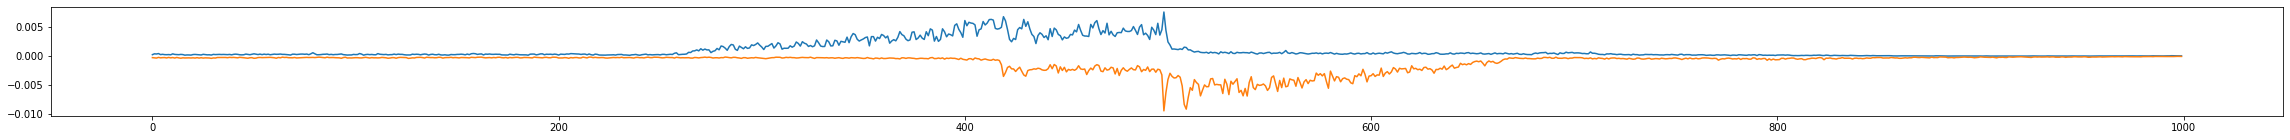

Grad*inp heatmap


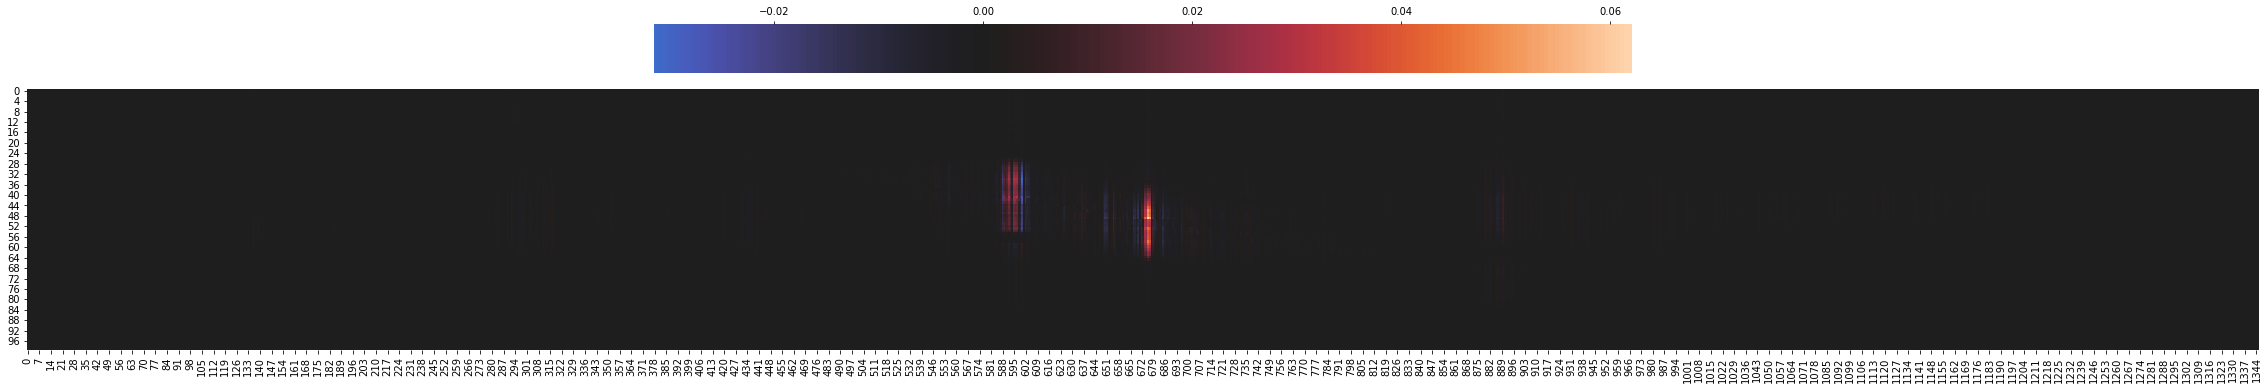

DeepSHAP heatmap


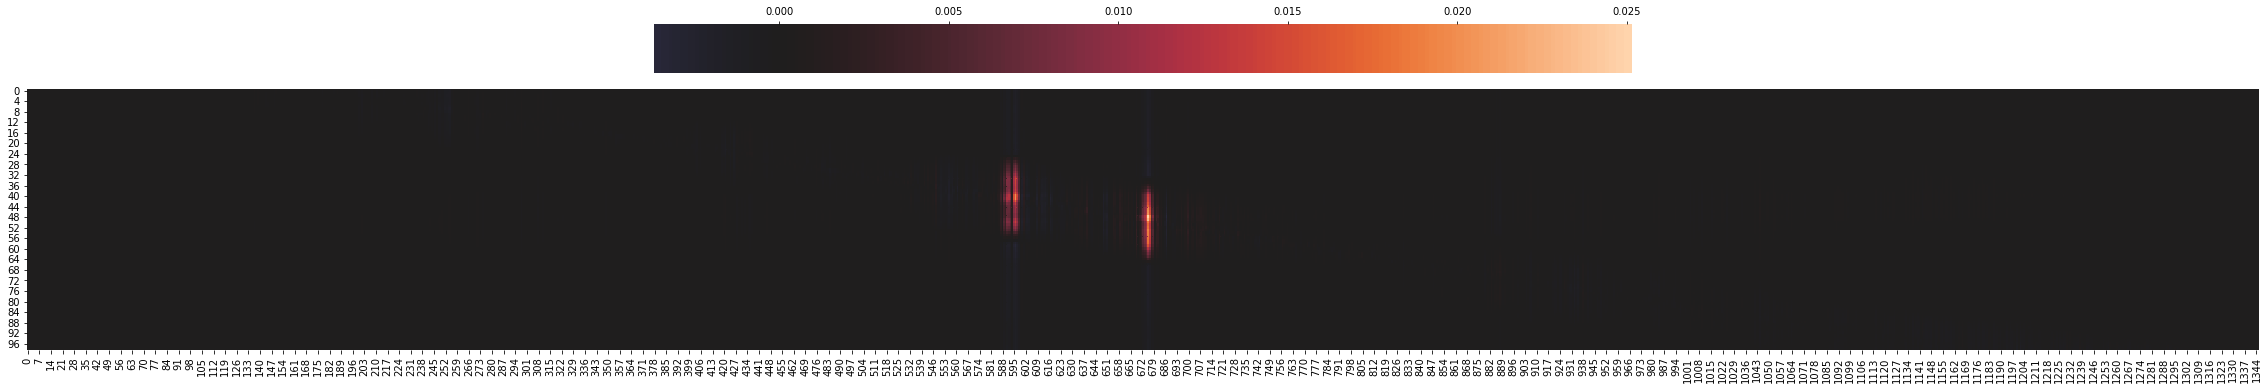

Summing ABSOLUTE grad*inp across all output positions


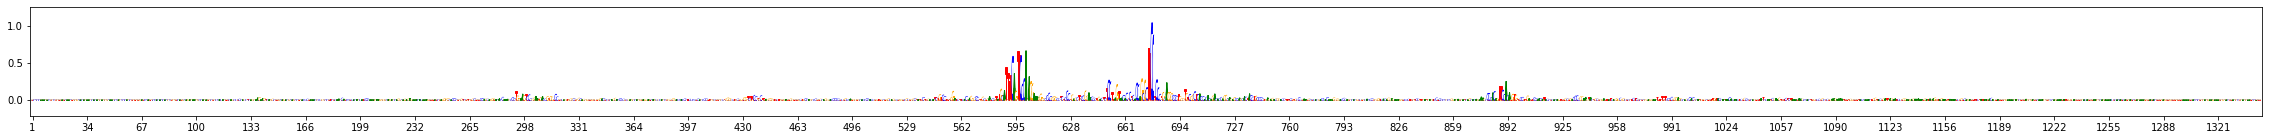

Summing ORIGINAL grad*inp across all output positions


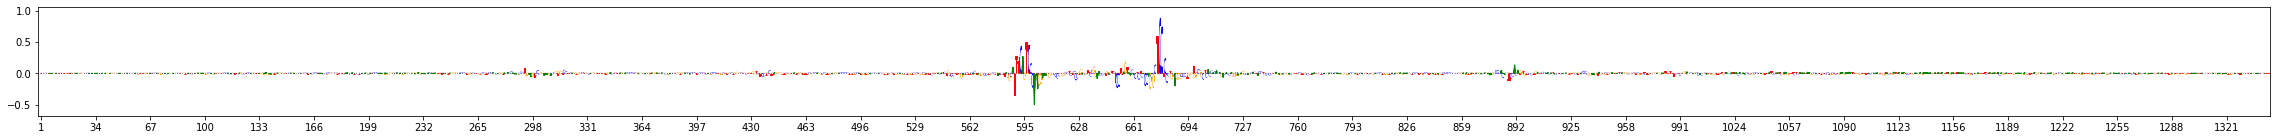

Summing ABSOLUTE deepshap across all output positions


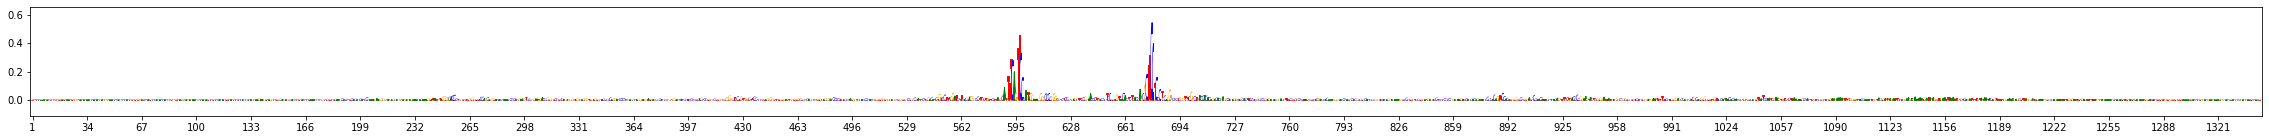

Summing ORIGINAL deepshap across all output positions


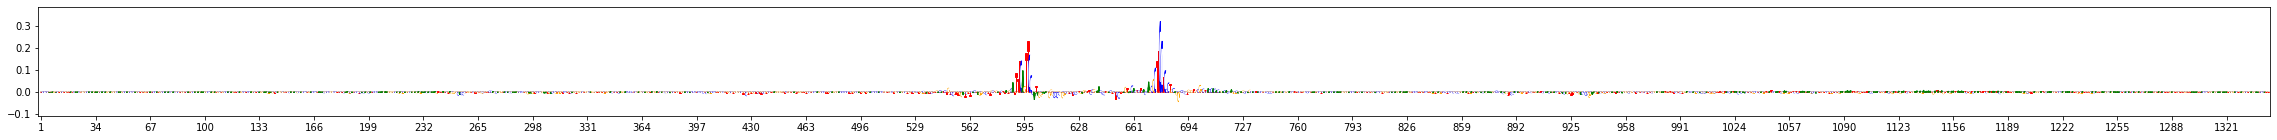

Plotting Example Index 1


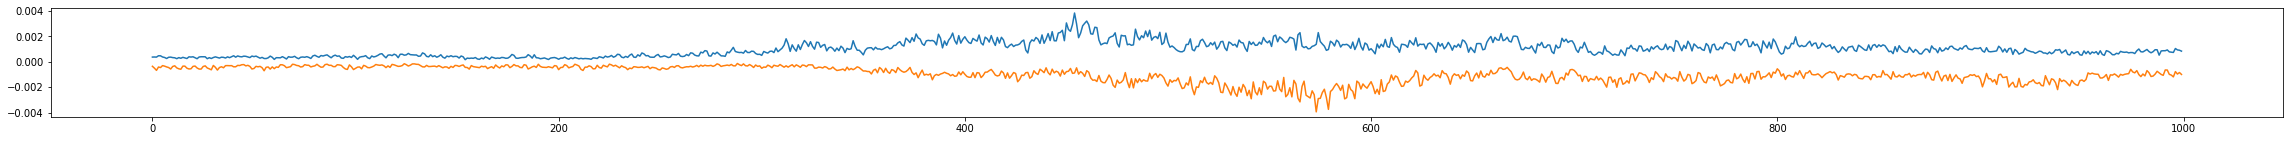

Grad*inp heatmap


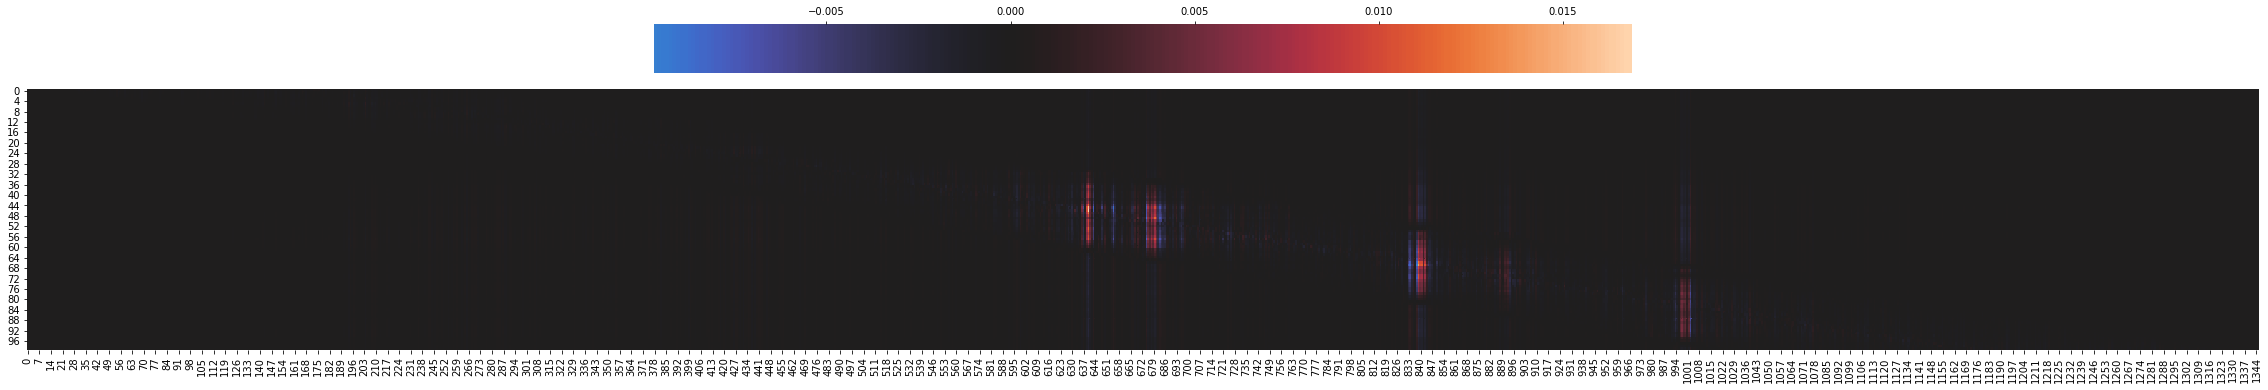

DeepSHAP heatmap


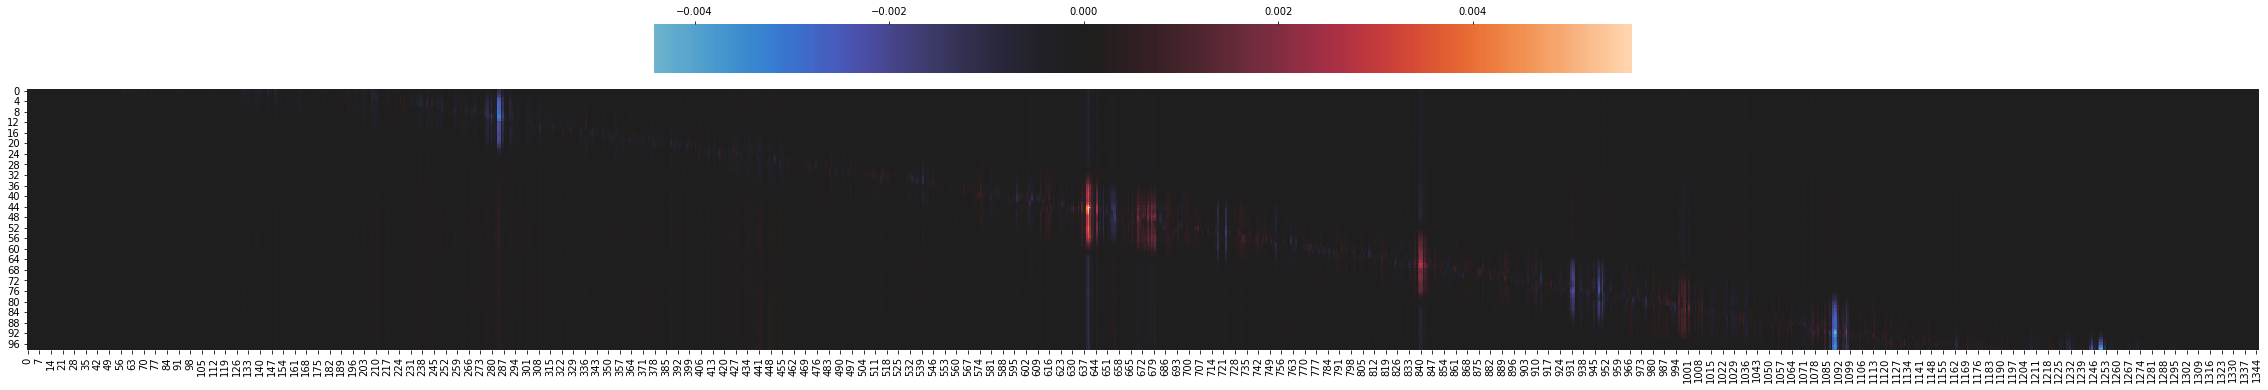

Summing ABSOLUTE grad*inp across all output positions


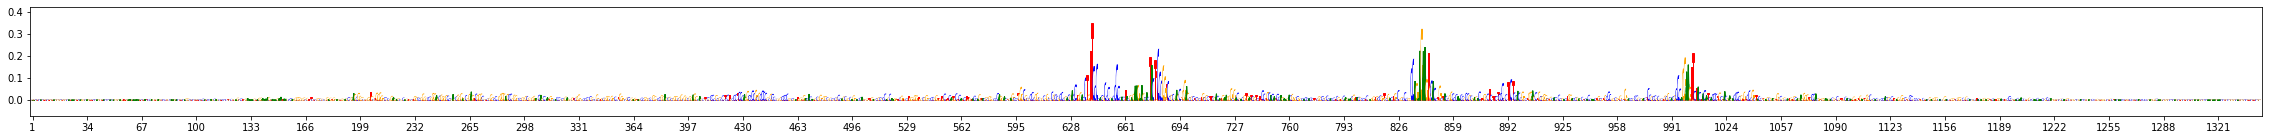

Summing ORIGINAL grad*inp across all output positions


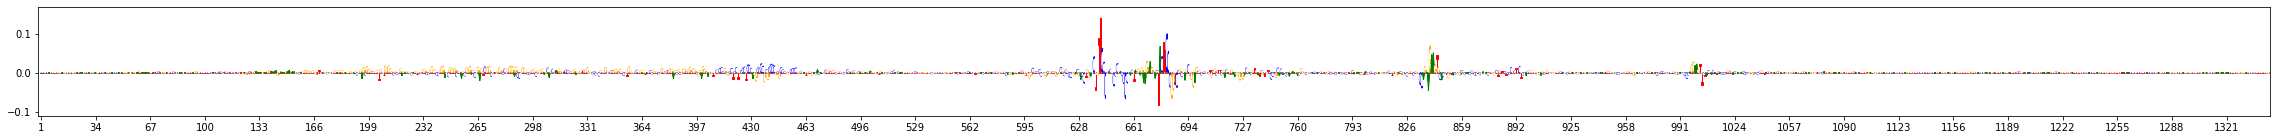

Summing ABSOLUTE deepshap across all output positions


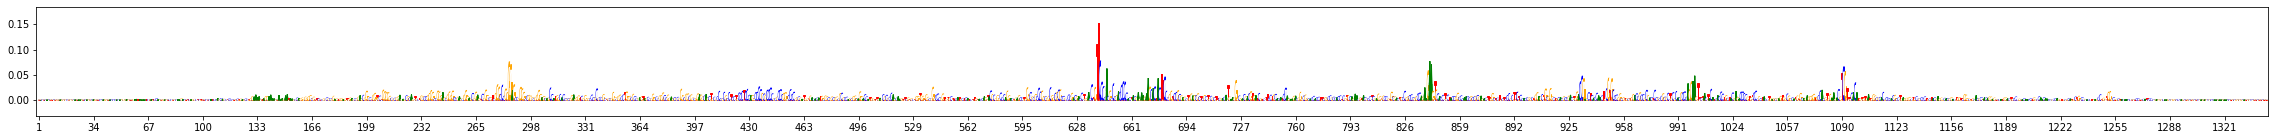

Summing ORIGINAL deepshap across all output positions


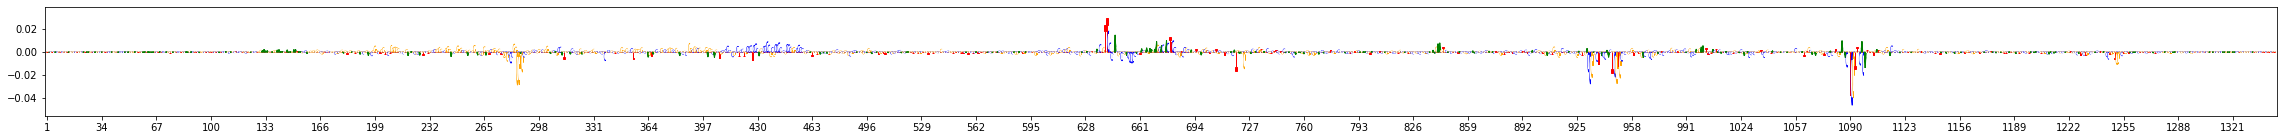

In [14]:
import vizsequence

#For visualization purposes, let's project the gradients onto the one-hot
# encoded sequence and then sum across the ACGT axis (axis -1) to get
# a gradient at each position
perposition_grads = np.sum(grads_for_slices*onehot_sequences[:,None], axis=-1)
perposition_deepshap = np.sum(deepshap_for_slices*onehot_sequences[:,None], axis=-1)
#At each position, we can sum up the absolute value of the per-position gradients
sumacrossout_abs_perposition_grads = np.sum(np.abs(perposition_grads), axis=1)
sumacrossout_abs_perposition_deepshap = np.sum(np.abs(perposition_deepshap), axis=1)
#For comparison, we'll also contrast to what the gradients are when we don't
# take the absolute value prior to summing
sumacrossout_perposition_grads = np.sum(perposition_grads, axis=1)
sumacrossout_perposition_deepshap = np.sum(perposition_deepshap, axis=1)

import seaborn as sns
from matplotlib import pyplot as plt

def viz_example(example_idx):
  print("Plotting Example Index", example_idx)
  plt.figure(figsize=(40,2))
  plt.plot(predicted_profiles[example_idx][:,0])
  plt.plot(-predicted_profiles[example_idx][:,1])
  plt.show()
  plt.figure(figsize=(40,6))

  print("Grad*inp heatmap")
  sns.heatmap(perposition_grads[example_idx], center=0,
              cbar_kws = dict(use_gridspec=False,location="top"))
  plt.show()

  print("DeepSHAP heatmap")
  plt.figure(figsize=(40,6))
  sns.heatmap(perposition_deepshap[example_idx], center=0,
              cbar_kws = dict(use_gridspec=False,location="top"))
  plt.show()

  print("Summing ABSOLUTE grad*inp across all output positions")
  vizsequence.plot_weights(
      sumacrossout_abs_perposition_grads[example_idx][:,None]
      *onehot_sequences[example_idx],
      figsize=(40,2))
  print("Summing ORIGINAL grad*inp across all output positions")
  vizsequence.plot_weights(
      sumacrossout_perposition_grads[example_idx][:,None]
      *onehot_sequences[example_idx],
      figsize=(40,2))
  print("Summing ABSOLUTE deepshap across all output positions")
  vizsequence.plot_weights(
      sumacrossout_abs_perposition_deepshap[example_idx][:,None]
      *onehot_sequences[example_idx],
      figsize=(40,2))
  print("Summing ORIGINAL deepshap across all output positions")
  vizsequence.plot_weights(
      sumacrossout_perposition_deepshap[example_idx][:,None]
      *onehot_sequences[example_idx],
      figsize=(40,2))

viz_example(example_idx=0)
viz_example(example_idx=1)

Plotting Example Index 2


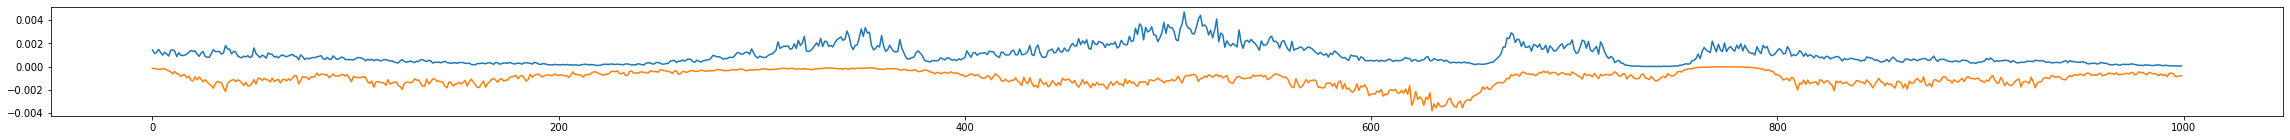

Grad*inp heatmap


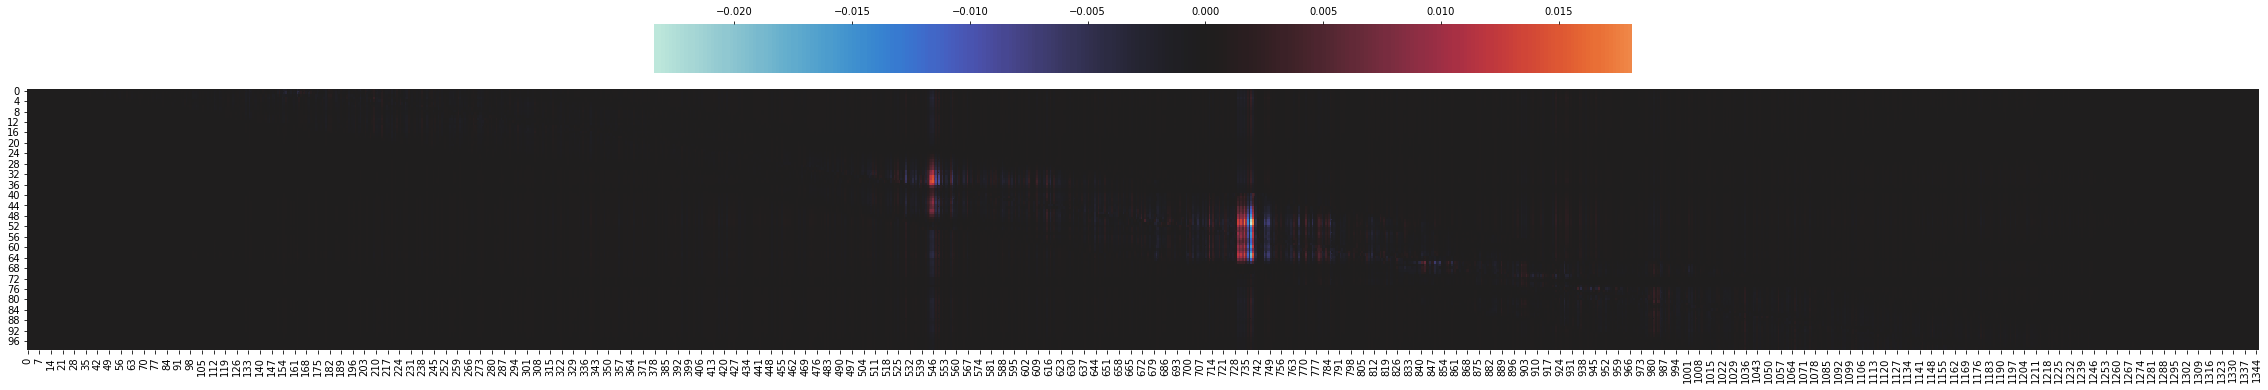

DeepSHAP heatmap


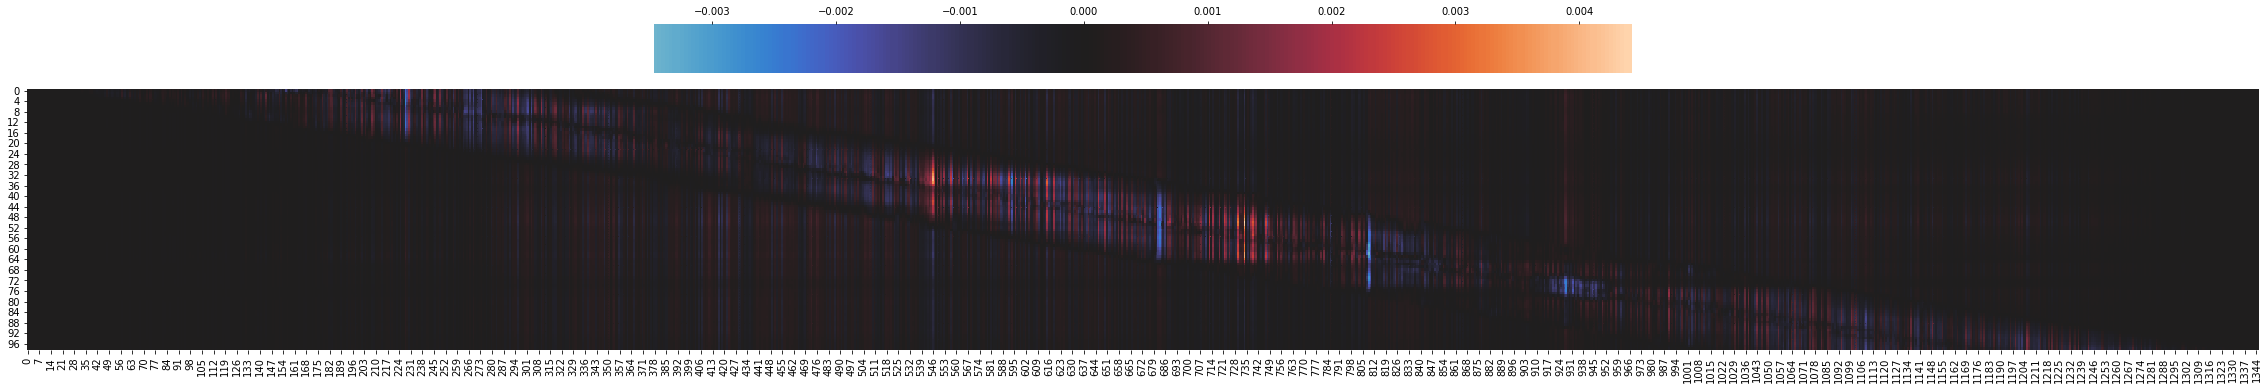

Summing ABSOLUTE grad*inp across all output positions


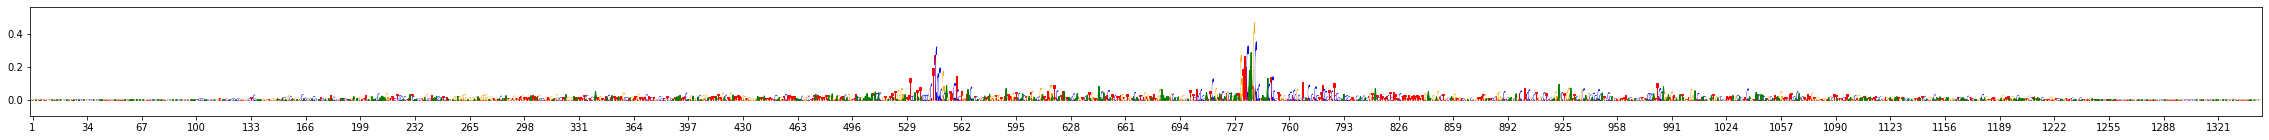

Summing ORIGINAL grad*inp across all output positions


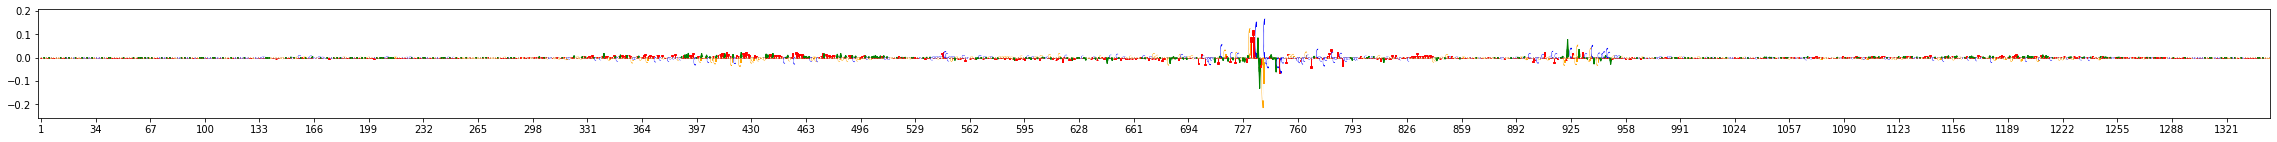

Summing ABSOLUTE deepshap across all output positions


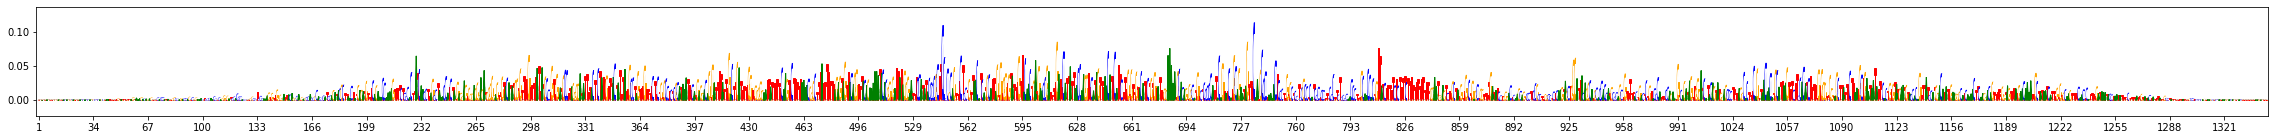

Summing ORIGINAL deepshap across all output positions


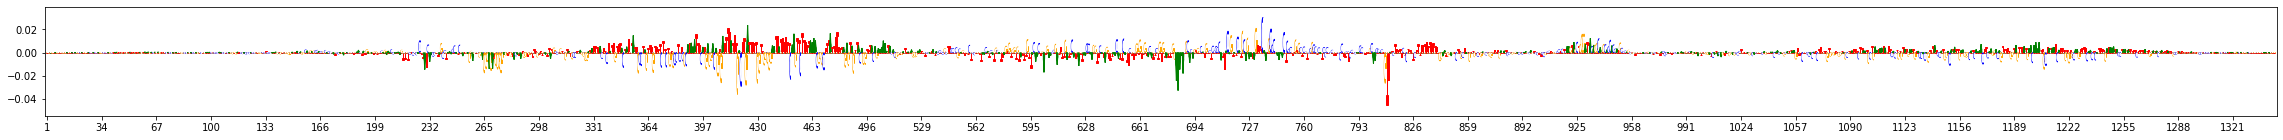

Plotting Example Index 3


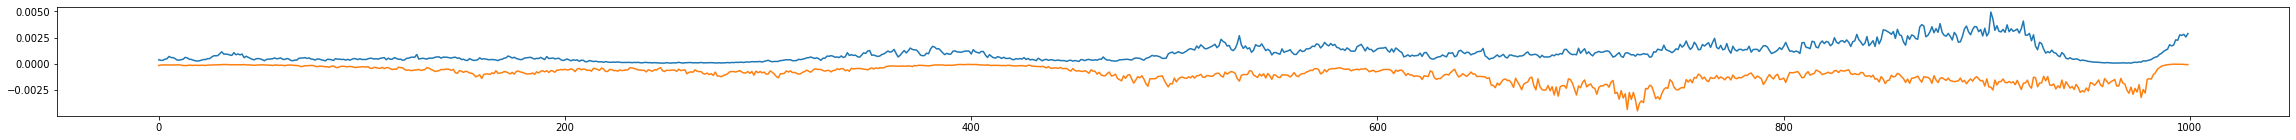

Grad*inp heatmap


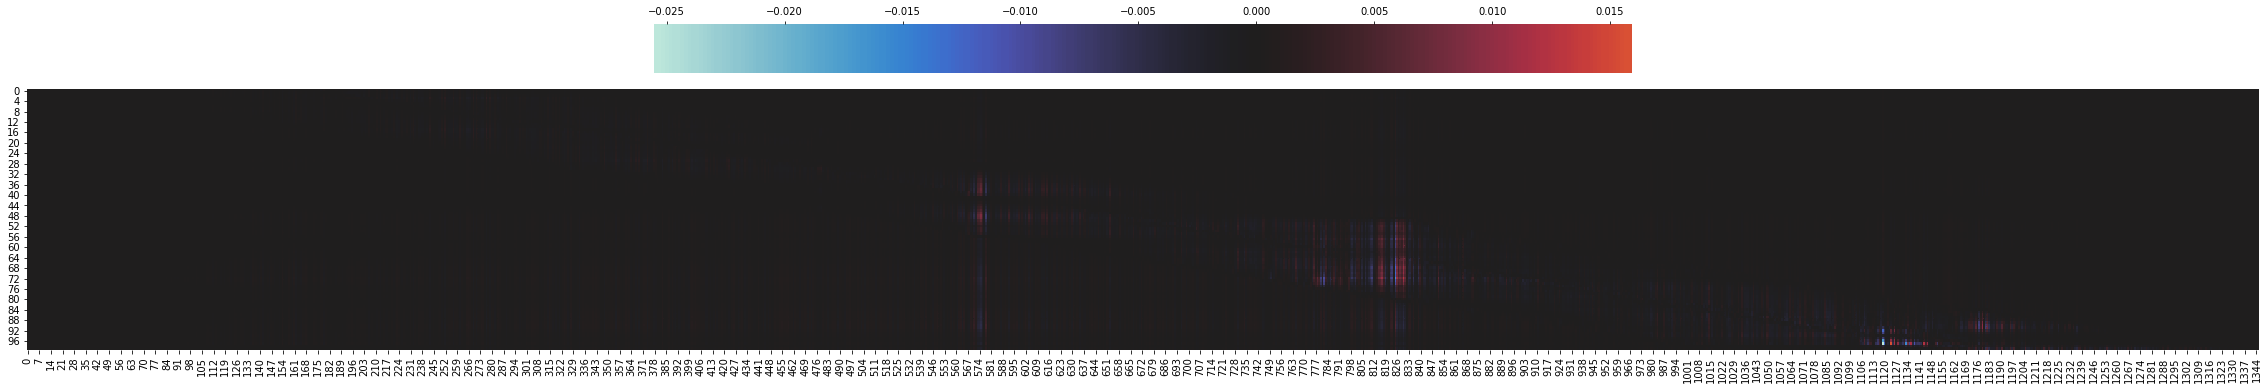

DeepSHAP heatmap


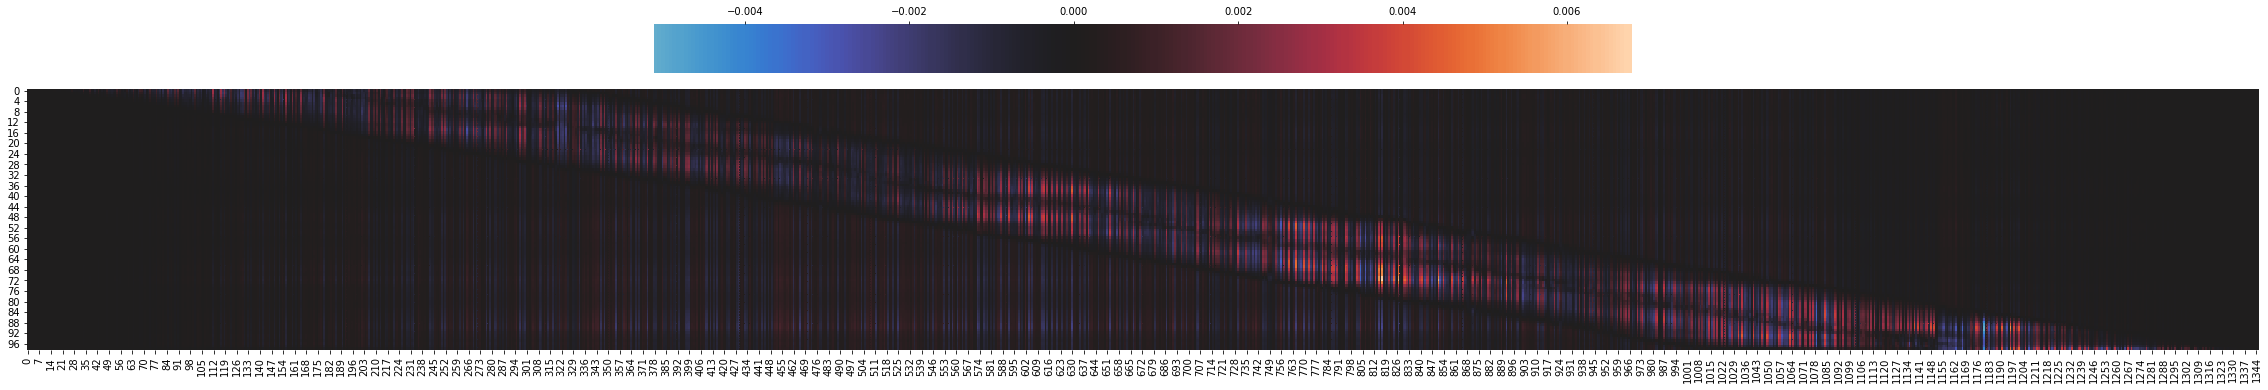

Summing ABSOLUTE grad*inp across all output positions


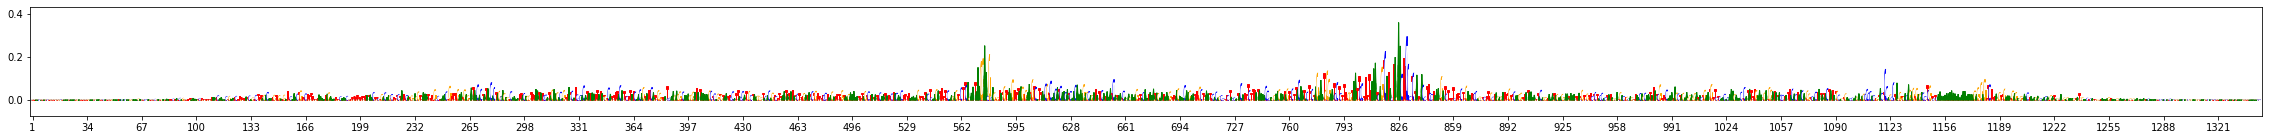

Summing ORIGINAL grad*inp across all output positions


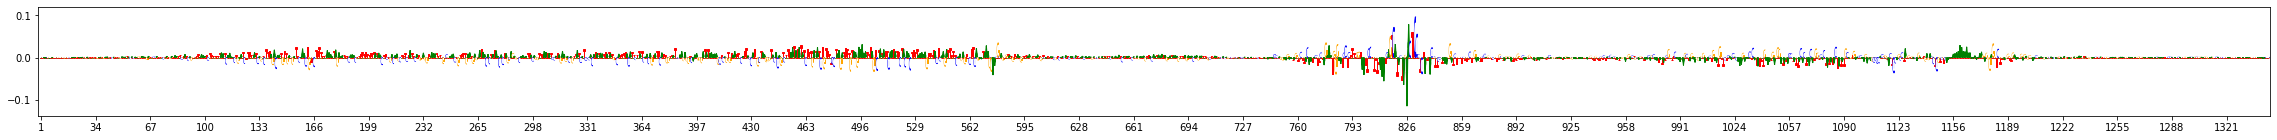

Summing ABSOLUTE deepshap across all output positions


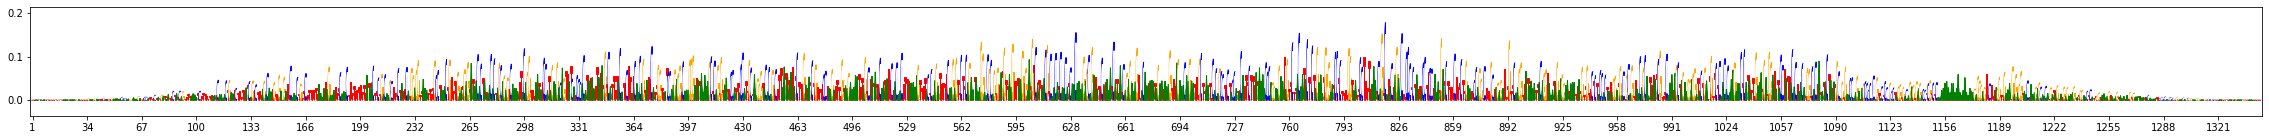

Summing ORIGINAL deepshap across all output positions


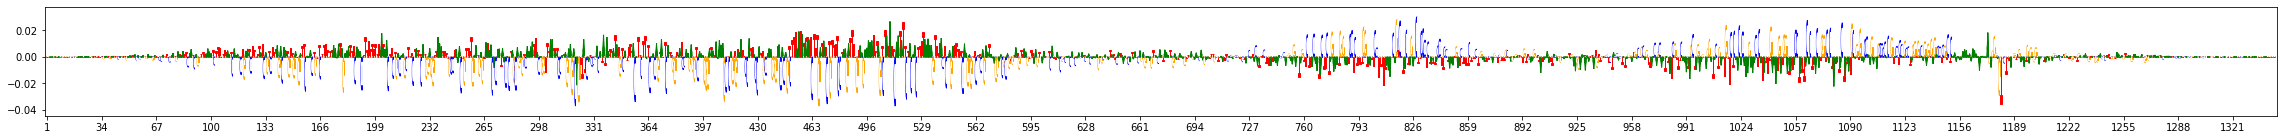

Plotting Example Index 4


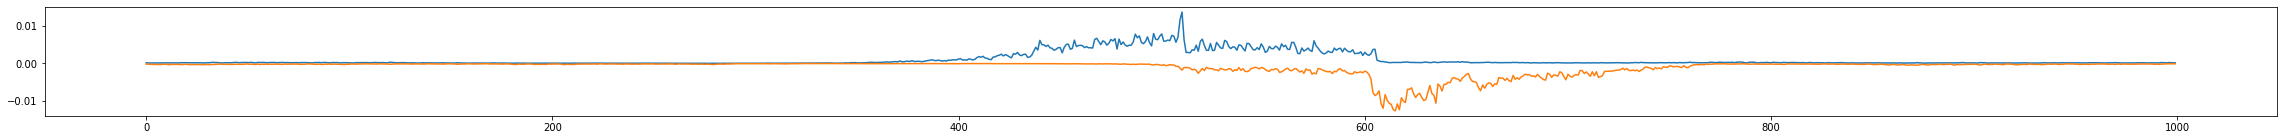

Grad*inp heatmap


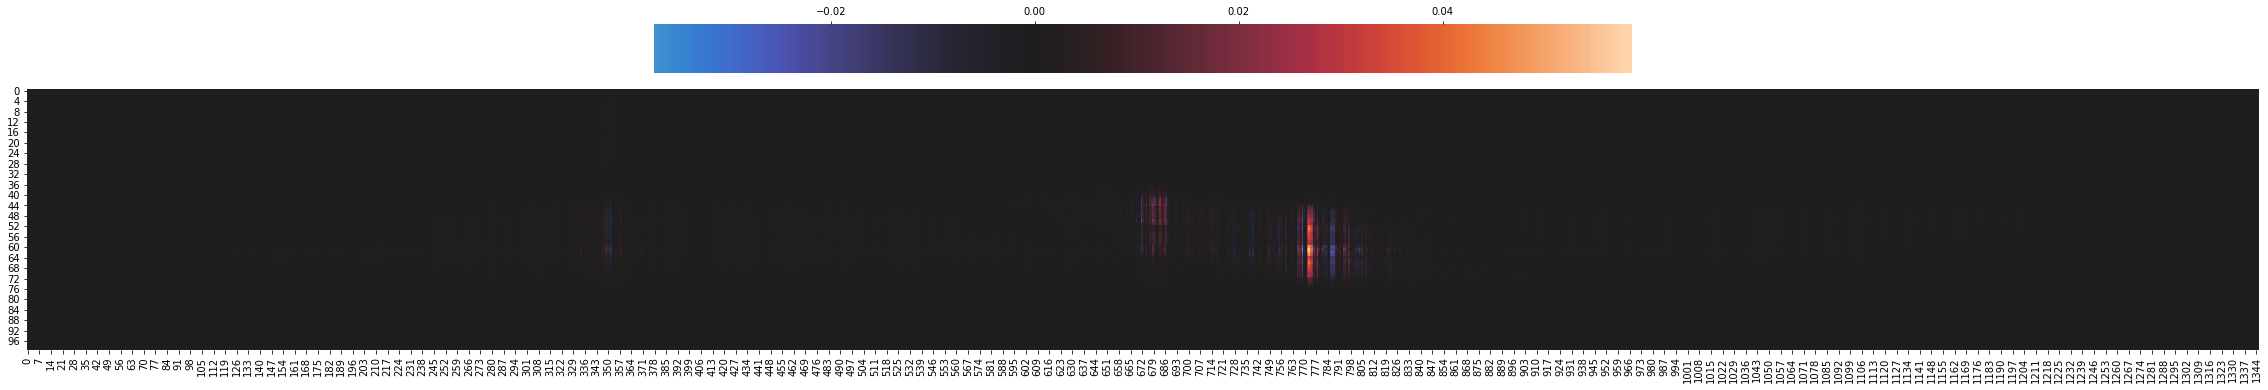

DeepSHAP heatmap


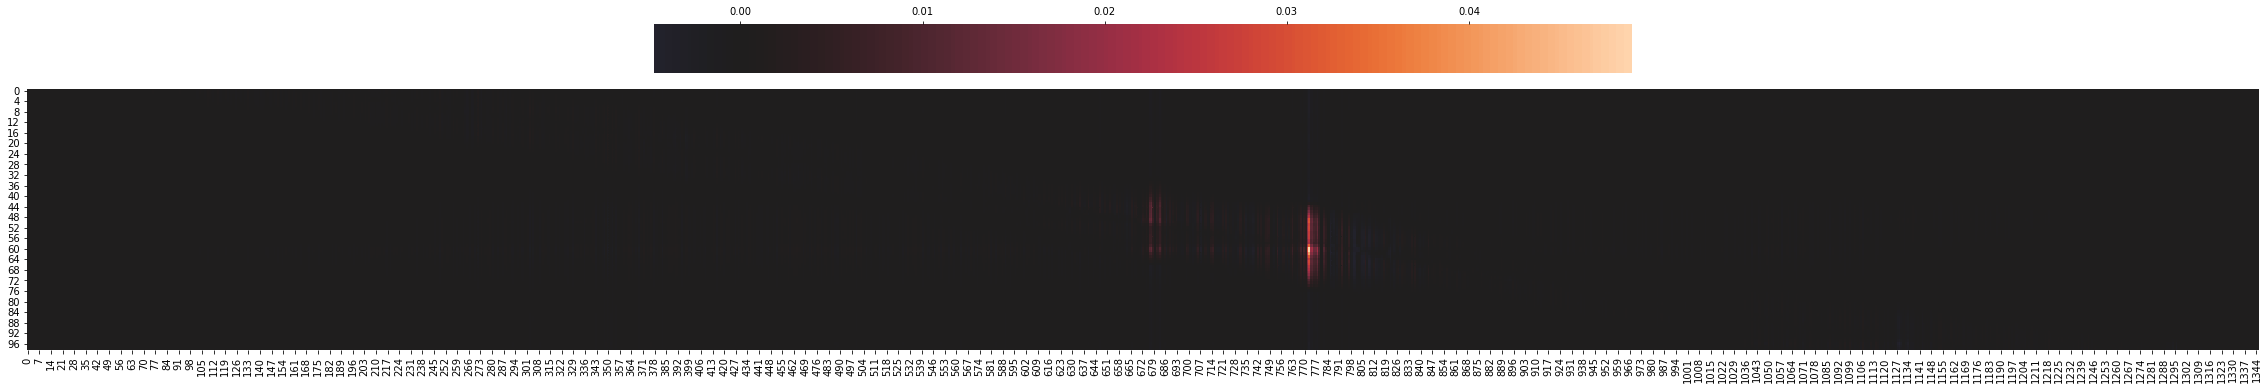

Summing ABSOLUTE grad*inp across all output positions


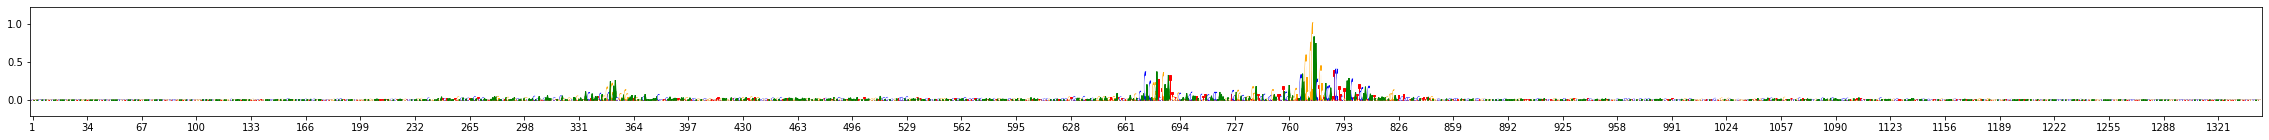

Summing ORIGINAL grad*inp across all output positions


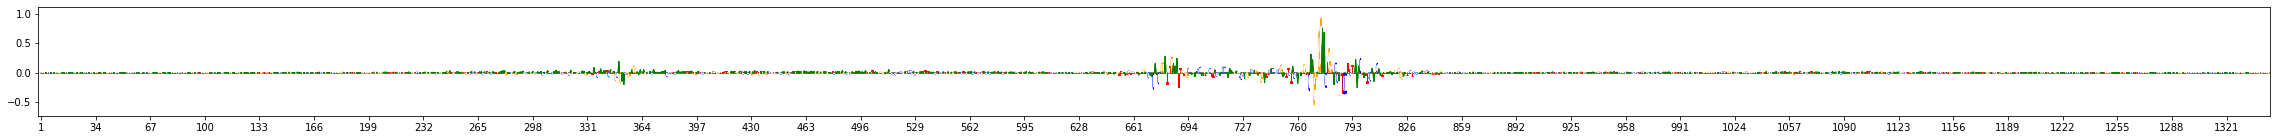

Summing ABSOLUTE deepshap across all output positions


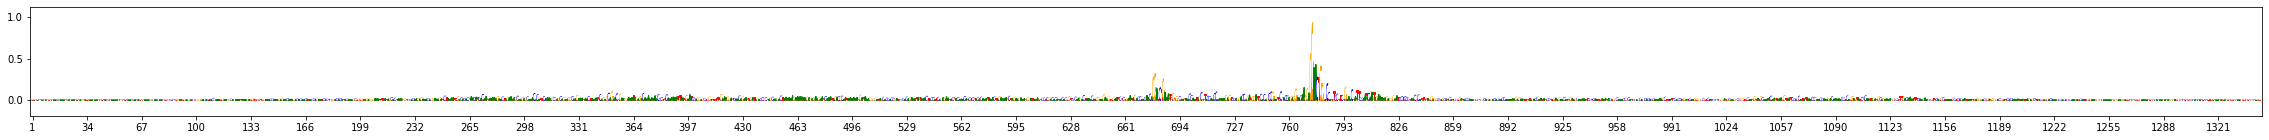

Summing ORIGINAL deepshap across all output positions


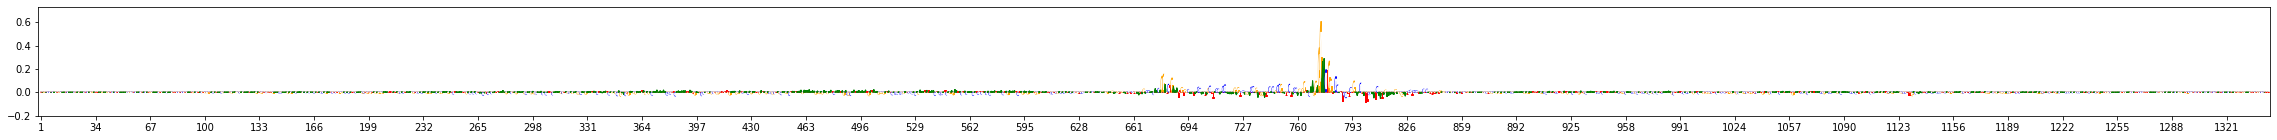

In [15]:
viz_example(example_idx=2)
viz_example(example_idx=3)
viz_example(example_idx=4)